# Read Me

I am using python2.7 for this project as it gives unsolvable "ImportError: ... Symbol not found: _inflateValidate" error on MacOS High Sierra once I run the notebook on python3 virtual env. I found it very common among High Sierra users but no one has a solid solution. And another problem is `helper.py` mysteriously breaking down (TypeError: load() got an unexpected keyword argument 'encoding') when I tried to use it by importing, but the exact same code works when I copy paste in notebook cell. (of course I treid remove `encoding` or change to cpickle method, but none of them work for me). Really sorry for the inconvience of reviewing!  But I was really not intentionlly ignoring the instructions, just I was hold by these issues for too long and I have to move on.

All code in this notebook has been run smoothly with python2.7 and the pasted helper code cell. Besides the small modification, none of the core code is modified.  


# Image Classification
In this project, you'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  You'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers.  At the end, you'll get to see your neural network's predictions on the sample images.
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# from urllib.request import urlretrieve
from urllib import urlretrieve

from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

Ask yourself "What are all possible labels?", "What is the range of values for the image data?", "Are the labels in order or random?".  Answers to questions like these will help you preprocess the data and end up with better predictions.

## helper.py code

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer


def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    batch = pickle.load(open(cifar10_dataset_folder_path+'/data_batch_' + str(batch_id), mode='rb'))
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)


def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)

        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file)

    # load the training data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all training data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_training.p')


def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)


def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 4:
Image - Min Value: 0 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


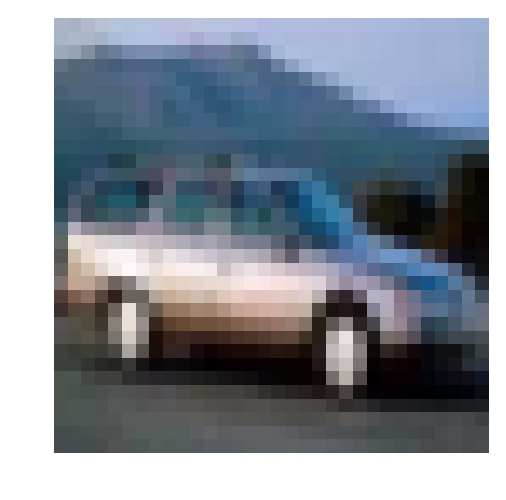

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 5
display_stats('cifar-10-batches-py',1,4)

## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [4]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    
    return x/255.


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_normalize(normalize)

Tests Passed


### One-hot encode
Just like the previous code cell, you'll be implementing a function for preprocessing.  This time, you'll implement the `one_hot_encode` function. The input, `x`, are a list of labels.  Implement the function to return the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`.  Make sure to save the map of encodings outside the function.

**Hint:**

Look into LabelBinarizer in the preprocessing module of sklearn.

In [5]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
classes = list(range(10))
lb.fit(classes)

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function
    
    return lb.transform(x)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_one_hot_encode(one_hot_encode)

Tests Passed


### Randomize Data
As you saw from exploring the data above, the order of the samples are randomized.  It doesn't hurt to randomize it again, but you don't need to for this dataset.

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Preprocess Training, Validation, and Testing Data
preprocess_and_save_data('cifar-10-batches-py', normalize, one_hot_encode)

# Check Point
This is your first checkpoint.  If you ever decide to come back to this notebook or have to restart the notebook, you can start from here.  The preprocessed data has been saved to disk.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle
import problem_unittests as tests

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, you'll build each layer into a function.  Most of the code you've seen has been outside of functions. To test your code more thoroughly, we require that you put each layer in a function.  This allows us to give you better feedback and test for simple mistakes using our unittests before you submit your project.

>**Note:** If you're finding it hard to dedicate enough time for this course each week, we've provided a small shortcut to this part of the project. In the next couple of problems, you'll have the option to use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages to build each layer, except the layers you build in the "Convolutional and Max Pooling Layer" section.  TF Layers is similar to Keras's and TFLearn's abstraction to layers, so it's easy to pickup.

>However, if you would like to get the most out of this course, try to solve all the problems _without_ using anything from the TF Layers packages. You **can** still use classes from other packages that happen to have the same name as ones you find in TF Layers! For example, instead of using the TF Layers version of the `conv2d` class, [tf.layers.conv2d](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d), you would want to use the TF Neural Network version of `conv2d`, [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d). 

Let's begin!

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. Implement the following functions
* Implement `neural_net_image_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `image_shape` with batch size set to `None`.
 * Name the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_label_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `n_classes` with batch size set to `None`.
 * Name the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * Name the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

These names will be used at the end of the project to load your saved model.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [8]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    # TODO: Implement Function
    
    xholder=tf.placeholder(tf.float32, [None, image_shape[0], image_shape[1], image_shape[2]], name='x')
    
    return xholder


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    # TODO: Implement Function
    
    yholder=tf.placeholder(tf.float32, [None, n_classes], name='y')
    return yholder


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    probholder=tf.placeholder(tf.float32, name='keep_prob')
    return probholder


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, you should implement the function `conv2d_maxpool` to apply convolution then max pooling:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.

**Note:** You **can't** use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for **this** layer, but you can still use TensorFlow's [Neural Network](https://www.tensorflow.org/api_docs/python/tf/nn) package. You may still use the shortcut option for all the **other** layers.

** Hint: **

When unpacking values as an argument in Python, look into the [unpacking](https://docs.python.org/3/tutorial/controlflow.html#unpacking-argument-lists) operator. 

In [9]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # TODO: Implement Function
    
    no_records,hight,width,depth=x_tensor.get_shape().as_list()
    
    #weights,biases,strides
    weights=tf.Variable(tf.truncated_normal((conv_ksize[0], conv_ksize[1], depth, conv_num_outputs),
                                mean=0.0, stddev=0.1))
    biases=tf.Variable(tf.zeros(conv_num_outputs))
    #Apply a convolution to x_tensor using weight and conv_strides,`same` padding
    layer=tf.nn.conv2d(x_tensor, weights, strides=[1, conv_strides[0], conv_strides[1], 1], padding='SAME')
    #Add bias 
    layer=tf.nn.bias_add(layer,biases)
    #Apply Max Pooling using pool_ksize and pool_strides.
    ksize = [1, pool_ksize[0], pool_ksize[1], 1]
    layer=tf.nn.max_pool(layer,ksize=ksize,strides=[1, pool_strides[0], pool_strides[1], 1],padding='SAME')
    #Add relu
    layer=tf.nn.relu(layer+biases)
    
    return layer 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer
Implement the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [10]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    return tf.contrib.layers.flatten(x_tensor)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer
Implement the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [11]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    return tf.contrib.layers.fully_connected(x_tensor, num_outputs, activation_fn=tf.nn.relu)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer
Implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

**Note:** Activation, softmax, or cross entropy should **not** be applied to this.

In [12]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    weights=tf.Variable(tf.truncated_normal((x_tensor.get_shape().as_list()[1],num_outputs)))
    biases=tf.Variable(tf.zeros(num_outputs))
    layer=tf.matmul(x_tensor,weights)+biases
    return layer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_output(output)

Tests Passed


### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  Use the layers you created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [13]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # TODO: Apply 1, 2, or 3 Convolution and Max Pool layers
    #    Play around with different number of outputs, kernel size and stride
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    layer=conv2d_maxpool(x,32,(3,3),(2,2),(2,2),(2,2))

    # TODO: Apply a Flatten Layer
    # Function Definition from Above:
    #   flatten(x_tensor)
    layer=flatten(layer)

    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    layer=fully_conn(layer,524)
    layer=tf.nn.dropout(layer,keep_prob=keep_prob)
    
    # TODO: Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    layer=output(layer,10)
    
    # TODO: return output
    return layer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization
Implement the function `train_neural_network` to do a single optimization.  The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [14]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    session.run(optimizer,{x:feature_batch,y:label_batch,keep_prob:keep_probability})


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats
Implement the function `print_stats` to print loss and validation accuracy.  Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  Use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [15]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # TODO: Implement Function    
    stat_loss = session.run(cost, feed_dict={x:feature_batch,y:label_batch,keep_prob:1.})    
    stat_acc = sess.run(accuracy, feed_dict={x: valid_features, y: valid_labels,keep_prob: 1.})    
    print('Loss: {}'.format(stat_loss))
    print('Validation Accuracy: {}'.format(stat_acc))
    

### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for.  Most people set them to common sizes of memory:
 * 64
 * 128
 * 256
 * ...
* Set `keep_probability` to the probability of keeping a node using dropout

In [16]:
# TODO: Tune Parameters
epochs = 100
batch_size = 128
keep_probability = 0.5

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i))
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  
Loss: 1.91161608696
Validation Accuracy: 0.368200004101
Epoch  2, CIFAR-10 Batch 1:  
Loss: 1.66117548943
Validation Accuracy: 0.446200013161
Epoch  3, CIFAR-10 Batch 1:  
Loss: 1.35454428196
Validation Accuracy: 0.490799993277
Epoch  4, CIFAR-10 Batch 1:  
Loss: 1.08717358112
Validation Accuracy: 0.504199981689
Epoch  5, CIFAR-10 Batch 1:  
Loss: 0.986618220806
Validation Accuracy: 0.529200017452
Epoch  6, CIFAR-10 Batch 1:  
Loss: 0.86057728529
Validation Accuracy: 0.534200012684
Epoch  7, CIFAR-10 Batch 1:  
Loss: 0.748840451241
Validation Accuracy: 0.530399978161
Epoch  8, CIFAR-10 Batch 1:  
Loss: 0.662040710449
Validation Accuracy: 0.549799978733
Epoch  9, CIFAR-10 Batch 1:  
Loss: 0.673417448997
Validation Accuracy: 0.530799984932
Epoch 10, CIFAR-10 Batch 1:  
Loss: 0.558808326721
Validation Accuracy: 0.555400013924
Epoch 11, CIFAR-10 Batch 1:  
Loss: 0.486946195364
Validation Accuracy: 0.558799982071
Epoch

Epoch 94, CIFAR-10 Batch 1:  
Loss: 0.000867848284543
Validation Accuracy: 0.562200009823
Epoch 95, CIFAR-10 Batch 1:  
Loss: 0.00117992458399
Validation Accuracy: 0.568799972534
Epoch 96, CIFAR-10 Batch 1:  
Loss: 0.00064239744097
Validation Accuracy: 0.571600019932
Epoch 97, CIFAR-10 Batch 1:  
Loss: 0.00088557752315
Validation Accuracy: 0.561200022697
Epoch 98, CIFAR-10 Batch 1:  
Loss: 0.00181830278598
Validation Accuracy: 0.563000023365
Epoch 99, CIFAR-10 Batch 1:  
Loss: 0.00130364042707
Validation Accuracy: 0.562600016594
Epoch 100, CIFAR-10 Batch 1:  
Loss: 0.000863261520863
Validation Accuracy: 0.555800020695


### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i))
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  
Loss: 1.91279828548
Validation Accuracy: 0.373800009489
Epoch  1, CIFAR-10 Batch 2:  
Loss: 1.60753440857
Validation Accuracy: 0.44319999218
Epoch  1, CIFAR-10 Batch 3:  
Loss: 1.50900685787
Validation Accuracy: 0.488999992609
Epoch  1, CIFAR-10 Batch 4:  
Loss: 1.43058896065
Validation Accuracy: 0.498199999332
Epoch  1, CIFAR-10 Batch 5:  
Loss: 1.40319633484
Validation Accuracy: 0.510999977589
Epoch  2, CIFAR-10 Batch 1:  
Loss: 1.37997674942
Validation Accuracy: 0.535199999809
Epoch  2, CIFAR-10 Batch 2:  
Loss: 1.18883931637
Validation Accuracy: 0.541000008583
Epoch  2, CIFAR-10 Batch 3:  
Loss: 1.11959791183
Validation Accuracy: 0.541599988937
Epoch  2, CIFAR-10 Batch 4:  
Loss: 1.18439614773
Validation Accuracy: 0.560400009155
Epoch  2, CIFAR-10 Batch 5:  
Loss: 1.1601703167
Validation Accuracy: 0.569599986076
Epoch  3, CIFAR-10 Batch 1:  
Loss: 1.16172468662
Validation Accuracy: 0.556599974632
Epoch  3, CIFAR-10 Batch 2:  
Loss: 0.977605

Epoch 20, CIFAR-10 Batch 1:  
Loss: 0.302442491055
Validation Accuracy: 0.64620000124
Epoch 20, CIFAR-10 Batch 2:  
Loss: 0.195014193654
Validation Accuracy: 0.643999993801
Epoch 20, CIFAR-10 Batch 3:  
Loss: 0.194967359304
Validation Accuracy: 0.638000011444
Epoch 20, CIFAR-10 Batch 4:  
Loss: 0.206956654787
Validation Accuracy: 0.646000027657
Epoch 20, CIFAR-10 Batch 5:  
Loss: 0.190243393183
Validation Accuracy: 0.647599995136
Epoch 21, CIFAR-10 Batch 1:  
Loss: 0.273433536291
Validation Accuracy: 0.645600020885
Epoch 21, CIFAR-10 Batch 2:  
Loss: 0.14738085866
Validation Accuracy: 0.640200018883
Epoch 21, CIFAR-10 Batch 3:  
Loss: 0.143541052938
Validation Accuracy: 0.642599999905
Epoch 21, CIFAR-10 Batch 4:  
Loss: 0.182806804776
Validation Accuracy: 0.639599978924
Epoch 21, CIFAR-10 Batch 5:  
Loss: 0.160869300365
Validation Accuracy: 0.65340000391
Epoch 22, CIFAR-10 Batch 1:  
Loss: 0.203303739429
Validation Accuracy: 0.647400021553
Epoch 22, CIFAR-10 Batch 2:  
Loss: 0.12690381

Epoch 38, CIFAR-10 Batch 5:  
Loss: 0.0580556206405
Validation Accuracy: 0.653199970722
Epoch 39, CIFAR-10 Batch 1:  
Loss: 0.0653033703566
Validation Accuracy: 0.652199983597
Epoch 39, CIFAR-10 Batch 2:  
Loss: 0.0517077930272
Validation Accuracy: 0.643400013447
Epoch 39, CIFAR-10 Batch 3:  
Loss: 0.0309295710176
Validation Accuracy: 0.648400008678
Epoch 39, CIFAR-10 Batch 4:  
Loss: 0.0335593298078
Validation Accuracy: 0.653599977493
Epoch 39, CIFAR-10 Batch 5:  
Loss: 0.0356866046786
Validation Accuracy: 0.654200017452
Epoch 40, CIFAR-10 Batch 1:  
Loss: 0.0568946674466
Validation Accuracy: 0.645799994469
Epoch 40, CIFAR-10 Batch 2:  
Loss: 0.0331824310124
Validation Accuracy: 0.638400018215
Epoch 40, CIFAR-10 Batch 3:  
Loss: 0.0360831841826
Validation Accuracy: 0.644999980927
Epoch 40, CIFAR-10 Batch 4:  
Loss: 0.0327101163566
Validation Accuracy: 0.651400029659
Epoch 40, CIFAR-10 Batch 5:  
Loss: 0.0375561006367
Validation Accuracy: 0.649999976158
Epoch 41, CIFAR-10 Batch 1:  
Lo

Loss: 0.00820423383266
Validation Accuracy: 0.642199993134
Epoch 57, CIFAR-10 Batch 4:  
Loss: 0.0193835441023
Validation Accuracy: 0.651400029659
Epoch 57, CIFAR-10 Batch 5:  
Loss: 0.0138348136097
Validation Accuracy: 0.64880001545
Epoch 58, CIFAR-10 Batch 1:  
Loss: 0.0222423374653
Validation Accuracy: 0.641799986362
Epoch 58, CIFAR-10 Batch 2:  
Loss: 0.00902194529772
Validation Accuracy: 0.636200010777
Epoch 58, CIFAR-10 Batch 3:  
Loss: 0.00784921925515
Validation Accuracy: 0.641399979591
Epoch 58, CIFAR-10 Batch 4:  
Loss: 0.0160678271204
Validation Accuracy: 0.640200018883
Epoch 58, CIFAR-10 Batch 5:  
Loss: 0.0108067840338
Validation Accuracy: 0.648400008678
Epoch 59, CIFAR-10 Batch 1:  
Loss: 0.0160749070346
Validation Accuracy: 0.648199975491
Epoch 59, CIFAR-10 Batch 2:  
Loss: 0.0162043292075
Validation Accuracy: 0.640799999237
Epoch 59, CIFAR-10 Batch 3:  
Loss: 0.00745651032776
Validation Accuracy: 0.646600008011
Epoch 59, CIFAR-10 Batch 4:  
Loss: 0.0109972879291
Validat

Epoch 76, CIFAR-10 Batch 1:  
Loss: 0.00858204625547
Validation Accuracy: 0.644599974155
Epoch 76, CIFAR-10 Batch 2:  
Loss: 0.00607672054321
Validation Accuracy: 0.632600009441
Epoch 76, CIFAR-10 Batch 3:  
Loss: 0.00210363743827
Validation Accuracy: 0.649399995804
Epoch 76, CIFAR-10 Batch 4:  
Loss: 0.00313494796865
Validation Accuracy: 0.642400026321
Epoch 76, CIFAR-10 Batch 5:  
Loss: 0.00852928124368
Validation Accuracy: 0.640200018883
Epoch 77, CIFAR-10 Batch 1:  
Loss: 0.0165803004056
Validation Accuracy: 0.643999993801
Epoch 77, CIFAR-10 Batch 2:  
Loss: 0.00462660193443
Validation Accuracy: 0.636600017548
Epoch 77, CIFAR-10 Batch 3:  
Loss: 0.00269056693651
Validation Accuracy: 0.649399995804
Epoch 77, CIFAR-10 Batch 4:  
Loss: 0.00429476331919
Validation Accuracy: 0.644200026989
Epoch 77, CIFAR-10 Batch 5:  
Loss: 0.00390976993367
Validation Accuracy: 0.646399974823
Epoch 78, CIFAR-10 Batch 1:  
Loss: 0.00874915998429
Validation Accuracy: 0.639800012112
Epoch 78, CIFAR-10 Bat

Loss: 0.00663432199508
Validation Accuracy: 0.643400013447
Epoch 94, CIFAR-10 Batch 4:  
Loss: 0.00266702426597
Validation Accuracy: 0.639999985695
Epoch 94, CIFAR-10 Batch 5:  
Loss: 0.00210401602089
Validation Accuracy: 0.643400013447
Epoch 95, CIFAR-10 Batch 1:  
Loss: 0.00510446121916
Validation Accuracy: 0.633000016212
Epoch 95, CIFAR-10 Batch 2:  
Loss: 0.00266321701929
Validation Accuracy: 0.628199994564
Epoch 95, CIFAR-10 Batch 3:  
Loss: 0.00169377517886
Validation Accuracy: 0.637799978256
Epoch 95, CIFAR-10 Batch 4:  
Loss: 0.00212554493919
Validation Accuracy: 0.638800024986
Epoch 95, CIFAR-10 Batch 5:  
Loss: 0.00265033636242
Validation Accuracy: 0.64099997282
Epoch 96, CIFAR-10 Batch 1:  
Loss: 0.00635044742376
Validation Accuracy: 0.633400022984
Epoch 96, CIFAR-10 Batch 2:  
Loss: 0.0014288170496
Validation Accuracy: 0.635399997234
Epoch 96, CIFAR-10 Batch 3:  
Loss: 0.00137820863165
Validation Accuracy: 0.649999976158
Epoch 96, CIFAR-10 Batch 4:  
Loss: 0.00272253225558


# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.644778481013



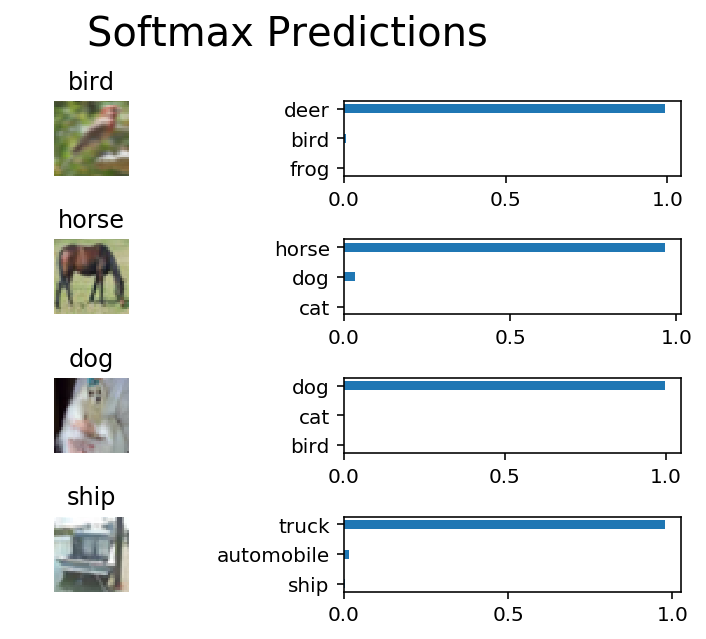

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Why 50-80% Accuracy?
You might be wondering why you can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN.  Pure guessing would get you 10% accuracy. That's because there are many more techniques that can be applied to your model and we recemmond that once you are done with this project, you explore!

## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook.  Save the notebook file as "image_classification.ipynb" and save it as a HTML file under "File" -> "Download as".  Include the "helper.py" and "problem_unittests.py" files in your submission.